#Transfer Learning

This notebook explores the basics of transfer learning. We will solve a problem of classifying images of *ants* and *bees*. The dataset is very small, only 120 traning images from each class and 75 validation images. Training a neural network from scratch would easily overfit. We will see that transfer learning can be used in this situation to train a model that generalizes well.

This is modified from the tutorial available [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

We first import packages.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import urllib.request
import zipfile

We now download the data and unzip the files.

In [2]:
urllib.request.urlretrieve('https://download.pytorch.org/tutorial/hymenoptera_data.zip','hymenoptera_data.zip')
with zipfile.ZipFile("hymenoptera_data.zip","r") as zip_ref:
    zip_ref.extractall(".")
!ls -l
!ls -l hymenoptera_data
!ls -l hymenoptera_data/train
!ls -l hymenoptera_data/val

total 46188
drwxr-xr-x 4 root root     4096 Jul 15 18:42 hymenoptera_data
-rw-r--r-- 1 root root 47286322 Jul 15 18:42 hymenoptera_data.zip
drwxr-xr-x 1 root root     4096 Jul 14 13:37 sample_data
total 8
drwxr-xr-x 4 root root 4096 Jul 15 18:42 train
drwxr-xr-x 4 root root 4096 Jul 15 18:42 val
total 16
drwxr-xr-x 2 root root  4096 Jul 15 18:42 ants
drwxr-xr-x 2 root root 12288 Jul 15 18:42 bees
total 8
drwxr-xr-x 2 root root 4096 Jul 15 18:42 ants
drwxr-xr-x 2 root root 4096 Jul 15 18:42 bees


To use a pretrained model, the images have to be preprocessed to have the same size and pixel intensity ranges that the model is trained on.
>All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

The data_transforms below apply these transformations, and also use *data augmentation* during training.

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

We now setup the dataloaders, datasets and devices (GPU or CPU).

In [5]:
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Let's now view some of the images from the training set, along with their labels. This also shows the *data augmentation* transforms, which are applied each time we access an image from the training set.

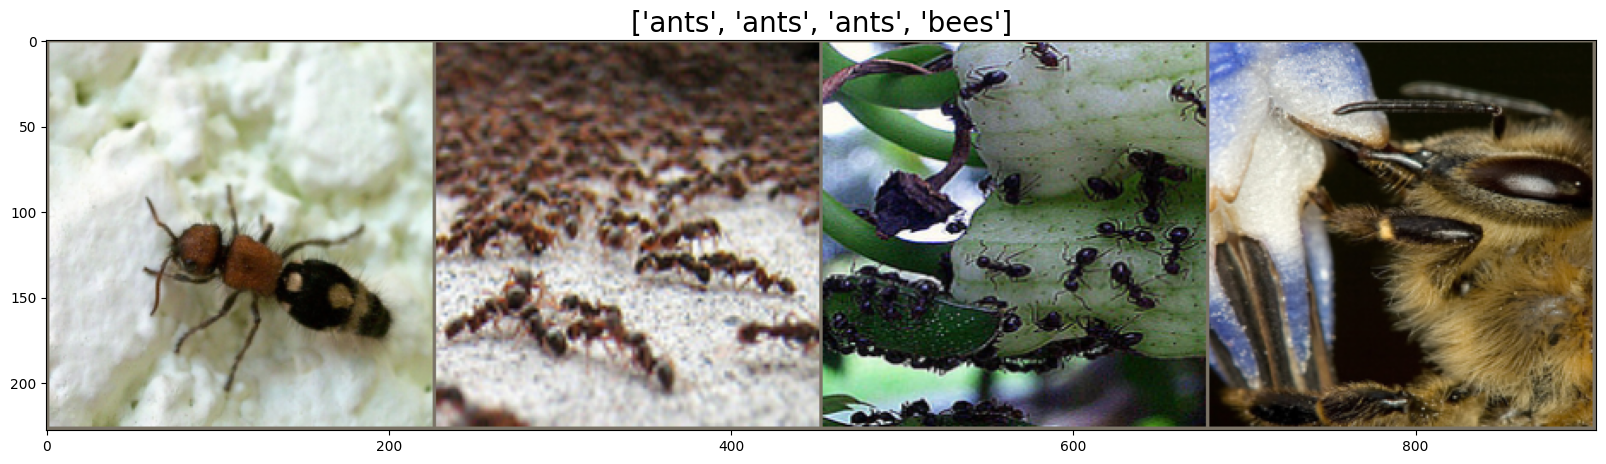

In [6]:
def imshow(inp, title=None, size=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if size is not None:
        plt.figure(figsize=(size,size))
    plt.imshow(inp)
    if title is not None:
        plt.title(title,fontsize=20)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes], size=20)

We define functions below for training the *pretrained* model, and for visualizing the classification predictions of the model.

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    outputs = nn.functional.log_softmax(outputs,dim=1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                imshow(inputs.cpu().data[j], title='predicted: {}'.format(class_names[preds[j]]), size = 7)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

We now load a pretrained *ResNet18* model and train it for our problem of classifying ants and bees. The choices for pretrained networks are shown [here](https://pytorch.org/vision/stable/models.html), along with their performance on the ImageNet problem.

In [8]:
#Load a pretrained ResNet18 network
model_ft = models.resnet18(weights='IMAGENET1K_V1')

#We now replace the final fully connected layer of the network
#With a new linear layer for our bees/ants problem with 2 outputs
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

# Set up the optimizer to optimize all model parameters
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#Train the model with cross entropy loss
criterion = nn.CrossEntropyLoss()
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 121MB/s]


Epoch 0/4
----------
train Loss: 0.5150 Acc: 0.7213
val Loss: 0.1700 Acc: 0.9346

Epoch 1/4
----------
train Loss: 0.6623 Acc: 0.7172
val Loss: 0.1956 Acc: 0.9150

Epoch 2/4
----------
train Loss: 0.6573 Acc: 0.7705
val Loss: 0.4305 Acc: 0.8431

Epoch 3/4
----------
train Loss: 0.4789 Acc: 0.8033
val Loss: 0.2175 Acc: 0.9085

Epoch 4/4
----------
train Loss: 0.4125 Acc: 0.8197
val Loss: 0.1653 Acc: 0.9477

Training complete in 7m 38s
Best val Acc: 0.947712


We now visualize some of the predictions of the model.

In [9]:
visualize_model(model_ft)

Output hidden; open in https://colab.research.google.com to view.

We can also freeze all the convolutional layers and just optimize over the final fully connected layer

In [10]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

#Replace fully connected layer by a new linear layer
#Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

#Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

#Train network with cross entropy loss
#Decay LR by a factor of 0.1 every 7 epochs
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6429 Acc: 0.5943
val Loss: 0.3860 Acc: 0.8301

Epoch 1/4
----------
train Loss: 0.4610 Acc: 0.7664
val Loss: 0.3048 Acc: 0.8562

Epoch 2/4
----------
train Loss: 0.4480 Acc: 0.7705
val Loss: 0.1840 Acc: 0.9412

Epoch 3/4
----------
train Loss: 0.5593 Acc: 0.7582
val Loss: 0.1837 Acc: 0.9477

Epoch 4/4
----------
train Loss: 0.5453 Acc: 0.7787
val Loss: 0.4029 Acc: 0.8497

Training complete in 3m 46s
Best val Acc: 0.947712


In [11]:
visualize_model(model_conv)

Output hidden; open in https://colab.research.google.com to view.

#Exercise
Try to adapt the transfer learning example to another dataset. For example, try the [sign language MNIST dataset](https://www.kaggle.com/datamunge/sign-language-mnist). We showed how to download this data in the [Fully Connected Neural Network Notebook](https://colab.research.google.com/drive/1ow3RJzr7fAa8bTjYnxKDmxmeKW0NEca5?usp=sharing). Or try a more interesting color image dataset from Kaggle.

The code below shows how to construct a torch Dataset for a sample dataset (MNIST). You need to factory reset the runtime (in the Runtime menu) before running the code below. Then also run the code block above that defines train_model and visualize_model.

In [13]:
from torchvision import datasets, transforms

transform = transforms.ToTensor()
train_data = datasets.CIFAR10("./data", train=True, transform=transform, download=True)

100%|██████████| 170M/170M [00:01<00:00, 105MB/s]


In [14]:
!pip install -q graphlearning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import urllib.request
import zipfile

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    outputs = nn.functional.log_softmax(outputs,dim=1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                imshow(inputs.cpu().data[j], title='predicted: {}'.format(class_names[preds[j]]), size = 7)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [16]:
import graphlearning as gl
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

#Load SignLanguageMNIST data
data, target = gl.datasets.load('signmnist')

#Convert to 3 color channels
data = np.reshape(data,(data.shape[0],28,28))
data = np.stack((data,data,data),axis=1)
print(data.shape)

#Convert to torch
data = torch.from_numpy(data).float()
target = torch.from_numpy(target).long()

(34627, 3, 28, 28)


In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image


class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
#We removed "ToTensor" since we already made the data a torch tensor
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
#Then we can construct a dataset and dataloader for train and testing data
train_size = 5000
val_size = 500
dataset_train = MyDataset(data[:train_size,:,:,:], target[:train_size], transform=data_transforms['train'])
dataloader_train = DataLoader(dataset_train, batch_size=64)

dataset_val = MyDataset(data[train_size:train_size+val_size,:,:,:], target[train_size:train_size+val_size], transform=data_transforms['val'])
dataloader_val = DataLoader(dataset_val, batch_size=64)

#Put together in python dictionary, like in this notebook
dataloaders = {'train':dataloader_train, 'val':dataloader_val}
dataset_sizes = {'train':train_size, 'val':val_size}
class_names = ['0','1','2','3','4','5','6','7','8','9']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The code block below is copied from the Bees and Ants example. You need to change it to work for a new dataset. The number of classes is now more than 2.

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

#Replace fully connected layer by a new linear layer
#Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2) #This is where the number of classes is specified
model_conv = model_conv.to(device)

#Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

#Train network with cross entropy loss
#Decay LR by a factor of 0.1 every 7 epochs
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 75.5MB/s]


Epoch 0/4
----------
train Loss: 3.1637 Acc: 0.0780
val Loss: 2.8746 Acc: 0.1800

Epoch 1/4
----------
train Loss: 2.8571 Acc: 0.1860
val Loss: 2.5230 Acc: 0.3500

Epoch 2/4
----------
train Loss: 2.6396 Acc: 0.2804
val Loss: 2.2630 Acc: 0.4300

Epoch 3/4
----------
train Loss: 2.4602 Acc: 0.3348
val Loss: 2.0542 Acc: 0.5460

Epoch 4/4
----------
train Loss: 2.3280 Acc: 0.3940
val Loss: 1.8821 Acc: 0.5960

Training complete in 1m 22s
Best val Acc: 0.596000
